# Pan005 Bottom Temperature for sector regions

In [1]:
import gsw
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45511/status,
Dashboard: /proxy/45511/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46001,Workers: 28
Dashboard: /proxy/45511/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:43135,Total threads: 1
Dashboard: /proxy/43737/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:45495,


In [4]:
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/outpu*/*.ocean_month_z.nc'))[120:]
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/outpu*/*.ocean_month_z.nc'))[:60]

In [5]:
## Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [6]:
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output239/20101201.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_005')

In [7]:
# Time variant variables
def preprocess(ds):
    ds = ds[['thetao','so']].where(shelf_mask == 1)
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [8]:
#Time slicing
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))
melt = melt.sel(time=slice('2001-01-01','2010-12-31'))

In [9]:
#Time invariant variables
area = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output239/20101201.ocean_static.nc')['areacello']

In [10]:
# Variable for landmask
saltC = cont['so']
saltM = melt['so']

In [11]:
# Correcting area
area_corr = area*(saltC.isel(time=0,z_l=0)*0 +1)

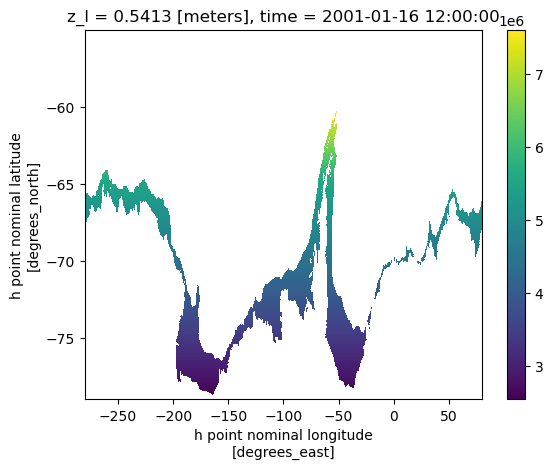

In [12]:
area_corr.plot()

### Defining the regions

In [13]:
# Define in longitude space what the cut-off values for regions should be.
AdelieW = -280
AdelieE = -200
RossW = -200
RossE = -150
AmW = -150
AmE = -100
BeW = -100
BeE = -65

WeddellW = -65
WeddellE = 0
PrydzW = 0
PrydzE = 80

Adelie = slice(AdelieW,AdelieE)
Ross = slice(RossW, RossE)
Am = slice(AmW, AmE)
Be = slice(BeW,BeE)
Weddell = slice(WeddellW, WeddellE)
Prydz = slice(PrydzW, PrydzE)

#### Getting data from full bottom temp files

Bottom temperature files were generated in `BottomTemperature_Pan005.ipynb`.

In [14]:
# Opening files
bottemp_cont = np.sort(glob.glob('/g/data/g40/kc5856/temperature_ssp126/pan005_cont_bottom_temp_*'))
bottemp_melt = np.sort(glob.glob('/g/data/g40/kc5856/temperature_ssp126/pan005_melt_bottom_temp_*'))

In [15]:
bottemp_cont = xr.open_mfdataset(bottemp_cont, concat_dim='time', combine='nested')
bottemp_melt = xr.open_mfdataset(bottemp_melt, concat_dim='time', combine='nested')

In [16]:
bottemp_cont

<xarray.Dataset> Size: 7GB
Dimensions:  (time: 120, yh: 1066, xh: 7200)
Coordinates:
  * xh       (xh) float64 58kB -280.0 -279.9 -279.9 -279.8 ... 79.87 79.92 79.97
  * yh       (yh) float64 9kB -78.99 -78.96 -78.94 ... -55.08 -55.05 -55.02
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2009-04-16 00:00:00
Data variables:
    so       (time, yh, xh) float64 7GB dask.array<chunksize=(1, 1066, 7200), meta=np.ndarray>

In [17]:
bottemp_cont = bottemp_cont.to_array().squeeze()
bottemp_melt = bottemp_melt.to_array().squeeze()

In [18]:
# To fix the label issues
#bottemp_cont = xr.DataArray(bottemp_cont, dims=cont['thetao'].dims, coords=cont['thetao'].coords)
bottemp_cont.attrs['units'] = '°C'
bottemp_cont.name = 'CT'

#bottemp_melt = xr.DataArray(bottemp_melt, dims=melt['thetao'].dims, coords=melt['thetao'].coords)
bottemp_melt.attrs['units'] = '°C'
bottemp_melt.name = 'CT'

In [19]:
bottemp_cont = bottemp_cont.sortby('time')
bottemp_melt = bottemp_melt.sortby('time')

In [20]:
bottemp_cont

<xarray.DataArray 'CT' (time: 120, yh: 1066, xh: 7200)> Size: 7GB
dask.array<getitem, shape=(120, 1066, 7200), dtype=float64, chunksize=(1, 1066, 7200), chunktype=numpy.ndarray>
Coordinates:
  * xh        (xh) float64 58kB -280.0 -279.9 -279.9 ... 79.87 79.92 79.97
  * yh        (yh) float64 9kB -78.99 -78.96 -78.94 ... -55.08 -55.05 -55.02
  * time      (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
    variable  <U2 8B 'so'
Attributes:
    units:    °C

## Time Series

In [21]:
bottemp_cont = bottemp_cont.astype(float)
bottemp_melt = bottemp_melt.astype(float)

In [22]:
bottemp_cont_shelf = bottemp_cont.where(shelf_mask == 1)
bottemp_pert_shelf = bottemp_melt.where(shelf_mask == 1)

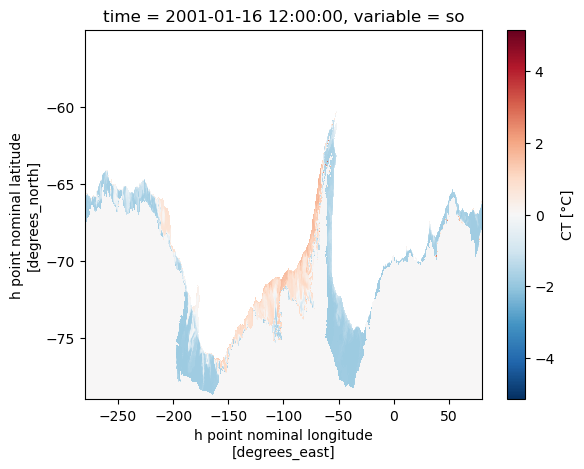

In [23]:
bottemp_cont_shelf.isel(time=0).plot()

In [24]:
# Restricting to regions
bottemp_cont_1 = bottemp_cont.sel(xh=Adelie)
bottemp_pert_1 = bottemp_melt.sel(xh=Adelie)

bottemp_cont_2 = bottemp_cont.sel(xh=Ross)
bottemp_pert_2 = bottemp_melt.sel(xh=Ross)

bottemp_cont_3 = bottemp_cont.sel(xh=Am)
bottemp_pert_3 = bottemp_melt.sel(xh=Am)

bottemp_cont_4 = bottemp_cont.sel(xh=Be)
bottemp_pert_4 = bottemp_melt.sel(xh=Be)

bottemp_cont_5 = bottemp_cont.sel(xh=Weddell)
bottemp_pert_5 = bottemp_melt.sel(xh=Weddell)

bottemp_cont_6 = bottemp_cont.sel(xh=Prydz)
bottemp_pert_6 = bottemp_melt.sel(xh=Prydz)

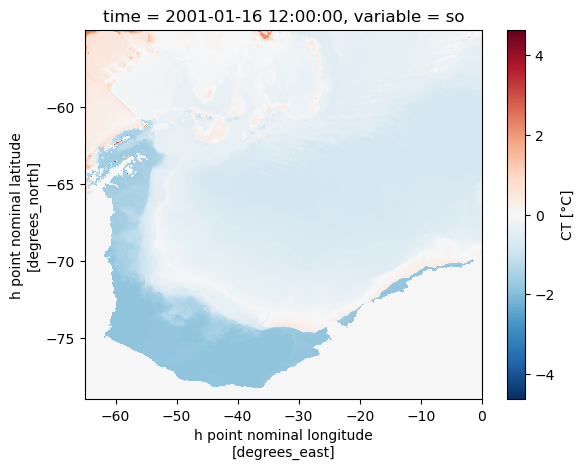

In [25]:
# Checking mask
bottemp_cont_5.isel(time=0).plot()

In [26]:
# Spatial averages
bottemp_cont_1_time = (area_corr * bottemp_cont_1).sum(['xh', 'yh']) / area_corr.sel(xh=Adelie).sum(['xh', 'yh'])
bottemp_pert_1_time = (area_corr * bottemp_pert_1).sum(['xh', 'yh']) / area_corr.sel(xh=Adelie).sum(['xh', 'yh'])

bottemp_cont_2_time = (area_corr * bottemp_cont_2).sum(['xh', 'yh']) / area_corr.sel(xh=Ross).sum(['xh', 'yh'])
bottemp_pert_2_time = (area_corr * bottemp_pert_2).sum(['xh', 'yh']) / area_corr.sel(xh=Ross).sum(['xh', 'yh'])

bottemp_cont_3_time = (area_corr * bottemp_cont_3).sum(['xh', 'yh']) / area_corr.sel(xh=Am).sum(['xh', 'yh'])
bottemp_pert_3_time = (area_corr * bottemp_pert_3).sum(['xh', 'yh']) / area_corr.sel(xh=Am).sum(['xh', 'yh'])

bottemp_cont_4_time = (area_corr * bottemp_cont_4).sum(['xh', 'yh']) / area_corr.sel(xh=Be).sum(['xh', 'yh'])
bottemp_pert_4_time = (area_corr * bottemp_pert_4).sum(['xh', 'yh']) / area_corr.sel(xh=Be).sum(['xh', 'yh'])

bottemp_cont_5_time = (area_corr * bottemp_cont_5).sum(['xh', 'yh']) / area_corr.sel(xh=Weddell).sum(['xh', 'yh'])
bottemp_pert_5_time = (area_corr * bottemp_pert_5).sum(['xh', 'yh']) / area_corr.sel(xh=Weddell).sum(['xh', 'yh'])

bottemp_cont_6_time = (area_corr * bottemp_cont_6).sum(['xh', 'yh']) / area_corr.sel(xh=Prydz).sum(['xh', 'yh'])
bottemp_pert_6_time = (area_corr * bottemp_pert_6).sum(['xh', 'yh']) / area_corr.sel(xh=Prydz).sum(['xh', 'yh'])

In [27]:
# Check shape
bottemp_cont_1_time

<xarray.DataArray (time: 120)> Size: 960B
dask.array<truediv, shape=(120,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    z_l       float64 8B 0.5413
  * time      (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
    variable  <U2 8B 'so'

In [28]:
bottemp_cont_1_time = bottemp_cont_1_time.load()
bottemp_pert_1_time = bottemp_pert_1_time.load()

In [29]:
bottemp_cont_2_time = bottemp_cont_2_time.load()
bottemp_pert_2_time = bottemp_pert_2_time.load()

In [30]:
bottemp_cont_3_time = bottemp_cont_3_time.load()
bottemp_pert_3_time = bottemp_pert_3_time.load()

In [31]:
bottemp_cont_4_time = bottemp_cont_4_time.load()
bottemp_pert_4_time = bottemp_pert_4_time.load()

In [32]:
bottemp_cont_5_time = bottemp_cont_5_time.load()
bottemp_pert_5_time = bottemp_pert_5_time.load()

In [33]:
bottemp_cont_6_time = bottemp_cont_6_time.load()
bottemp_pert_6_time = bottemp_pert_6_time.load()

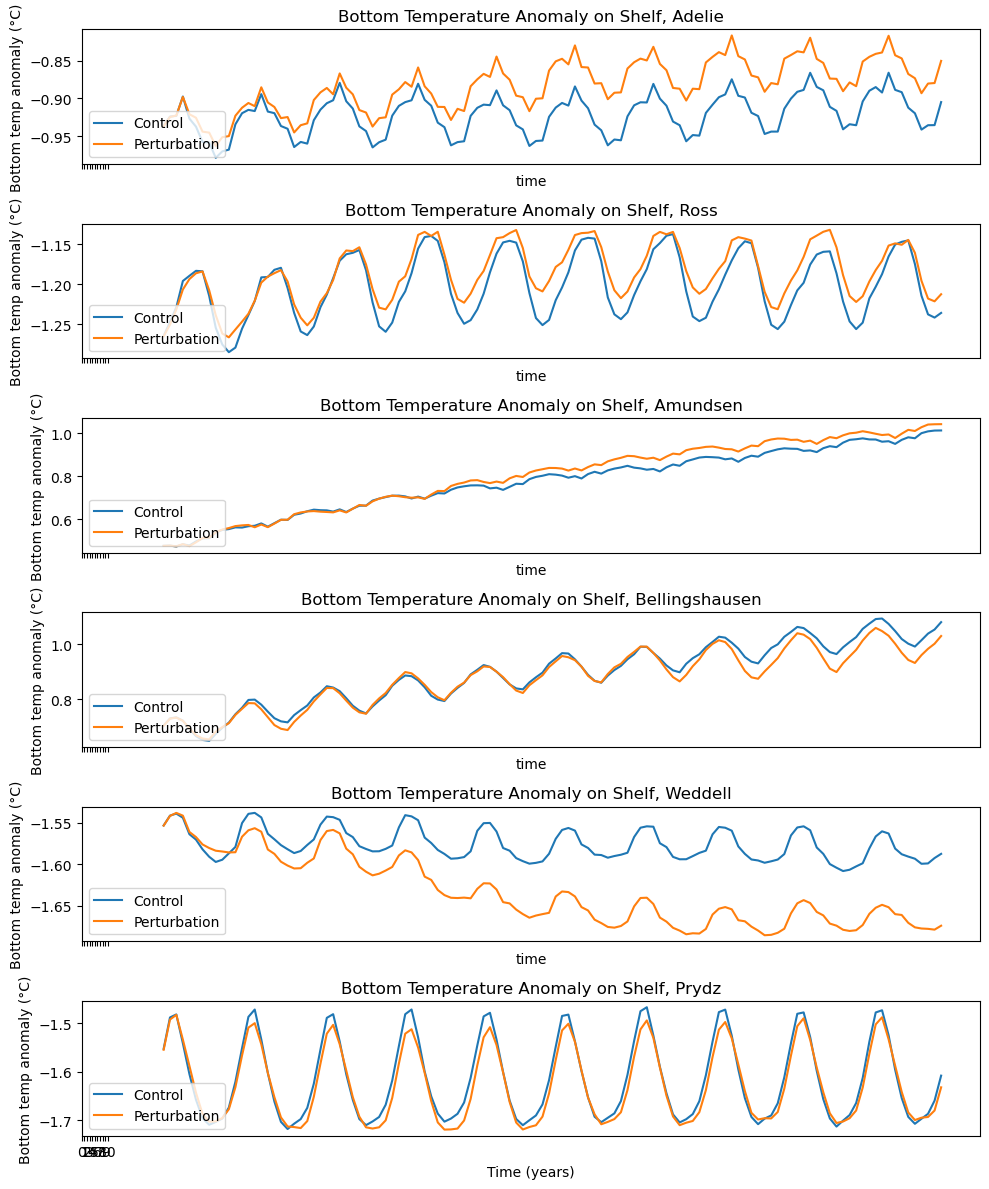

In [34]:
fig, axes = plt.subplots(
    nrows=6, ncols=1,
    sharex=True, figsize=(10, 12)
)

# First subplot: W_time
bottemp_cont_1_time.plot(ax=axes[0], label="Control")
bottemp_pert_1_time.plot(ax=axes[0], label="Perturbation")
axes[0].set_ylabel("Bottom temp anomaly (°C)")
axes[0].legend(loc="lower left")
axes[0].set_title("Bottom Temperature Anomaly on Shelf, Adelie")

# Second subplot: R_time
bottemp_cont_2_time.plot(ax=axes[1], label="Control")
bottemp_pert_2_time.plot(ax=axes[1], label="Perturbation")
axes[1].set_ylabel("Bottom temp anomaly (°C)")
axes[1].legend(loc="lower left")
axes[1].set_title("Bottom Temperature Anomaly on Shelf, Ross")

# Third subplot: A_time
bottemp_cont_3_time.plot(ax=axes[2], label="Control")
bottemp_pert_3_time.plot(ax=axes[2], label="Perturbation")
axes[2].set_ylabel("Bottom temp anomaly (°C)")
axes[2].legend(loc="lower left")
axes[2].set_title("Bottom Temperature Anomaly on Shelf, Amundsen")

# Fourth subplot: P_time
bottemp_cont_4_time.plot(ax=axes[3], label="Control")
bottemp_pert_4_time.plot(ax=axes[3], label="Perturbation")
axes[3].set_ylabel("Bottom temp anomaly (°C)")
axes[3].legend(loc="lower left")
axes[3].set_title("Bottom Temperature Anomaly on Shelf, Bellingshausen")

# Fifth subplot: P_time
bottemp_cont_5_time.plot(ax=axes[4], label="Control")
bottemp_pert_5_time.plot(ax=axes[4], label="Perturbation")
axes[4].set_ylabel("Bottom temp anomaly (°C)")
axes[4].legend(loc="lower left")
axes[4].set_title("Bottom Temperature Anomaly on Shelf, Weddell")

# Sixth subplot: P_time
bottemp_cont_6_time.plot(ax=axes[5], label="Control")
bottemp_pert_6_time.plot(ax=axes[5], label="Perturbation")
axes[5].set_ylabel("Bottom temp anomaly (°C)")
axes[5].legend(loc="lower left")
axes[5].set_title("Bottom Temperature Anomaly on Shelf, Prydz")

# Common X-axis label
axes[-1].set_xlabel("Time (years)")

# Set ticks every 12 months but label in years
ticks = range(0, 121, 12)  # 0 to 120 months
labels = [str(i) for i in range(len(ticks))]
plt.xticks(ticks=ticks, labels=labels)

# Adjust layout
plt.tight_layout()
plt.show()


In [35]:
bottemp_anom_1_time = bottemp_pert_1_time - bottemp_cont_1_time
bottemp_anom_1_time = bottemp_anom_1_time.load()
bottemp_anom_1_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Adelie_pan005.nc')

In [36]:
bottemp_anom_2_time = bottemp_pert_2_time - bottemp_cont_2_time
bottemp_anom_2_time = bottemp_anom_2_time.load()
bottemp_anom_2_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Ross_pan005.nc')

In [37]:
bottemp_anom_3_time = bottemp_pert_3_time - bottemp_cont_3_time
bottemp_anom_3_time = bottemp_anom_3_time.load()
bottemp_anom_3_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Am_pan005.nc')

In [38]:
bottemp_anom_4_time = bottemp_pert_4_time - bottemp_cont_4_time
bottemp_anom_4_time = bottemp_anom_4_time.load()
bottemp_anom_4_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Be_pan005.nc')

In [39]:
bottemp_anom_5_time = bottemp_pert_5_time - bottemp_cont_5_time
bottemp_anom_5_time = bottemp_anom_5_time.load()
bottemp_anom_5_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Weddell_pan005.nc')

In [40]:
bottemp_anom_6_time = bottemp_pert_6_time - bottemp_cont_6_time
bottemp_anom_6_time = bottemp_anom_6_time.load()
bottemp_anom_6_time.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Prydz_pan005.nc')

### All regions in one plot

Text(0.5, 1.0, 'Pan005 Time Series of Bottom Temperature on Shelf, Sector regions')

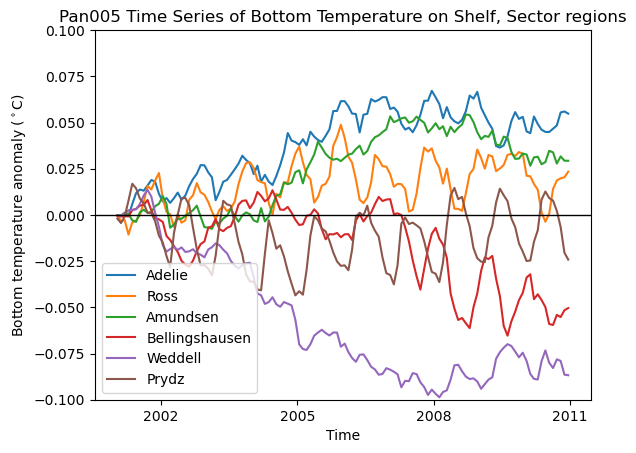

In [50]:
bottemp_anom_1_time.plot(label="Adelie",linewidth=1)
bottemp_anom_2_time.plot(label="Ross")
bottemp_anom_3_time.plot(label="Amundsen")
bottemp_anom_4_time.plot(label="Bellingshausen")
bottemp_anom_5_time.plot(label="Weddell")
bottemp_anom_6_time.plot(label="Prydz")
plt.ylim(-0.1,0.1)
plt.axhline(y=0, color='black', linewidth=1)
plt.ylabel("Bottom temperature anomaly ($^\circ$C)")
plt.xlabel("Time")
plt.legend(loc="lower left")
plt.title("Pan005 Time Series of Bottom Temperature on Shelf, Sector regions")

## Between model comparison

In [42]:
# Importing data
pan01_bottemp_1 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Adelie_pan01.nc', chunks = 'auto') 
pan005_bottemp_1 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Adelie_pan005.nc', chunks = 'auto')

pan01_bottemp_2 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Ross_pan01.nc', chunks = 'auto') 
pan005_bottemp_2 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Ross_pan005.nc', chunks = 'auto')

pan01_bottemp_3 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Am_pan01.nc', chunks = 'auto') 
pan005_bottemp_3 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Am_pan005.nc', chunks = 'auto')

pan01_bottemp_4 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Be_pan01.nc', chunks = 'auto') 
pan005_bottemp_4 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Be_pan005.nc', chunks = 'auto')

pan01_bottemp_5 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Weddell_pan01.nc', chunks = 'auto') 
pan005_bottemp_5 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Weddell_pan005.nc', chunks = 'auto')

pan01_bottemp_6 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Prydz_pan01.nc', chunks = 'auto') 
pan005_bottemp_6 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/bottemp_anom_Prydz_pan005.nc', chunks = 'auto')

In [43]:
pan01_bottemp_1_new = pan01_bottemp_1.to_series()
pan005_bottemp_1_new = pan005_bottemp_1.to_series()

pan01_bottemp_2_new = pan01_bottemp_2.to_series()
pan005_bottemp_2_new = pan005_bottemp_2.to_series()

pan01_bottemp_3_new = pan01_bottemp_3.to_series()
pan005_bottemp_3_new = pan005_bottemp_3.to_series()

pan01_bottemp_4_new = pan01_bottemp_4.to_series()
pan005_bottemp_4_new = pan005_bottemp_4.to_series()

pan01_bottemp_5_new = pan01_bottemp_5.to_series()
pan005_bottemp_5_new = pan005_bottemp_5.to_series()

pan01_bottemp_6_new = pan01_bottemp_6.to_series()
pan005_bottemp_6_new = pan005_bottemp_6.to_series()


In [44]:
import pandas as pd

In [45]:
# Reset index to normalized months
pan01_bottemp_1_new.index = range(0, len(pan01_bottemp_1_new))
pan005_bottemp_1_new.index = range(0, len(pan005_bottemp_1_new))

pan01_bottemp_2_new.index = range(0, len(pan01_bottemp_2_new))
pan005_bottemp_2_new.index = range(0, len(pan005_bottemp_2_new))

pan01_bottemp_3_new.index = range(0, len(pan01_bottemp_3_new))
pan005_bottemp_3_new.index = range(0, len(pan005_bottemp_3_new))

pan01_bottemp_4_new.index = range(0, len(pan01_bottemp_4_new))
pan005_bottemp_4_new.index = range(0, len(pan005_bottemp_4_new))

pan01_bottemp_5_new.index = range(0, len(pan01_bottemp_5_new))
pan005_bottemp_5_new.index = range(0, len(pan005_bottemp_5_new))

pan01_bottemp_6_new.index = range(0, len(pan01_bottemp_6_new))
pan005_bottemp_6_new.index = range(0, len(pan005_bottemp_6_new))

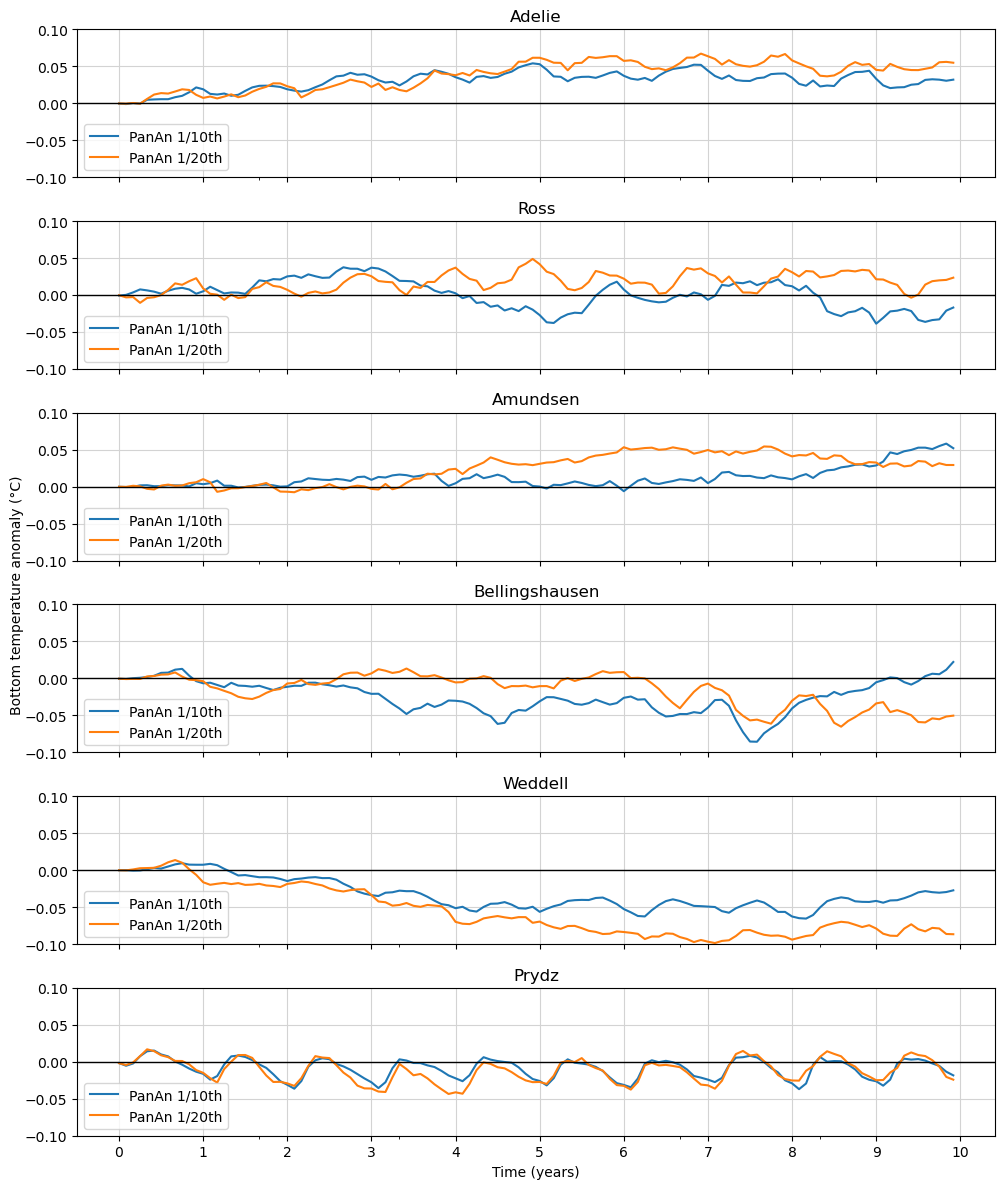

In [46]:
fig, axes = plt.subplots(
    nrows=6, ncols=1,
    sharex=True, figsize=(10, 12)
)

# First subplot: 
pan01_bottemp_1_new.plot(ax=axes[0], label="PanAn 1/10th")
pan005_bottemp_1_new.plot(ax=axes[0], label="PanAn 1/20th")
axes[0].legend(loc="lower left")
axes[0].set_title("Adelie")

# Second subplot: 
pan01_bottemp_2_new.plot(ax=axes[1], label="PanAn 1/10th")
pan005_bottemp_2_new.plot(ax=axes[1], label="PanAn 1/20th")
axes[1].legend(loc="lower left")
axes[1].set_title("Ross")

# Third subplot: 
pan01_bottemp_3_new.plot(ax=axes[2], label="PanAn 1/10th")
pan005_bottemp_3_new.plot(ax=axes[2], label="PanAn 1/20th")
axes[2].legend(loc="lower left")
axes[2].set_title("Amundsen")

# Fourth subplot: 
pan01_bottemp_4_new.plot(ax=axes[3], label="PanAn 1/10th")
pan005_bottemp_4_new.plot(ax=axes[3], label="PanAn 1/20th")
axes[3].legend(loc="lower left")
axes[3].set_title("Bellingshausen")

# Fifth subplot: 
pan01_bottemp_5_new.plot(ax=axes[4], label="PanAn 1/10th")
pan005_bottemp_5_new.plot(ax=axes[4], label="PanAn 1/20th")
axes[4].legend(loc="lower left")
axes[4].set_title("Weddell")

# Sixth subplot: 
pan01_bottemp_6_new.plot(ax=axes[5], label="PanAn 1/10th")
pan005_bottemp_6_new.plot(ax=axes[5], label="PanAn 1/20th")
axes[5].legend(loc="lower left")
axes[5].set_title("Prydz")

# Apply consistent y-limits and horizontal line for all subplots
for ax in axes:
    ax.axhline(y=0, color='black', linewidth=1)
    ax.set_ylim(-0.1, 0.1)
    ax.grid(True, color='lightgrey')

# Common X-axis label
axes[-1].set_xlabel("Time (years)")

# Common Y-axis label
fig.text(0, 0.5, "Bottom temperature anomaly (°C)", va='center', rotation='vertical')

# Set ticks every 12 months but label in years
ticks = range(0, 121, 12)  # 0 to 120 months
labels = [str(i) for i in range(len(ticks))]
plt.xticks(ticks=ticks, labels=labels)

# Adjust layout
plt.tight_layout()
plt.show()